In [ ]:
cd drive/MyDrive/AMLS_II_assignment


/content/drive/MyDrive/AMLS_II_assignment


In [ ]:
%pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 5.8 MB/s eta 0:00:00


# CODE

In [ ]:
import os
import matplotlib.pyplot as plt

## PATHS
PROJECT_PATH = os.path.abspath(".")
DATASET_PATH = os.path.join(PROJECT_PATH, "./Data")

## ORIGINAL HIGH RES
# ORIGINAL_DS = os.path.join(DATASET_PATH, "HR")
ORIGINAL_DS = os.path.join(DATASET_PATH, "HR2")
ORIGINAL_DS_TRAIN = os.path.join(ORIGINAL_DS, "DIV2K_train_HR")
ORIGINAL_DS_TEST = os.path.join(ORIGINAL_DS, "DIV2K_test_HR")
ORIGINAL_DS_VAL = os.path.join(ORIGINAL_DS, "DIV2K_val_HR")


# LR
LR = os.path.join(DATASET_PATH, "X8")
LR_TRAIN = os.path.join(LR, "DIV2K_train_LR")
LR_TEST = os.path.join(LR, "DIV2K_test_LR")
LR_VAL = os.path.join(LR, "DIV2K_val_LR")

In [ ]:
import os

import cv2
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

#from utils import costants


class SuperResolutionDataset(Dataset):
    """
    Custom PyTorch dataset used to train models in the
    Image Super Resolution  framework.
    """

    def __init__(self, hr_path, lr_path, transform_both, transform_hr, transform_lr):
        self.transform_both = transform_both
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr
        self.hr_path = hr_path
        self.lr_path = lr_path
        self.list_couples_hr_lr = self.build_list_couples_hr_lr()


    def build_list_couples_hr_lr(self):
        """
        Builds a list of tuples that contain the path of a HR image and
        the path of the corresponding LR image.

        Returns:
            list_couples_hr_lr (List): contains tuples that contain
            the path of a HR image and the path of the corresponding LR image, in
            the following form (hr_path, lr_path).
        """
        hr_images = os.listdir(self.hr_path)
        list_couples_hr_lr = []

        for hr_image_name in hr_images:
            if ".png" in hr_image_name:
                id_num = hr_image_name.split(".")[0]
                lr_image_name = id_num +"x4(x8).png"
                hr_image_path = os.path.join(self.hr_path, hr_image_name)
                lr_image_path = os.path.join(self.lr_path, lr_image_name)
                list_couples_hr_lr.append((hr_image_path, lr_image_path))

        list_couples_hr_lr.sort(key=lambda x: int(x[0].split("/")[-1].split(".")[0]))

        return list_couples_hr_lr


    def __len__(self):
        return len(self.list_couples_hr_lr)


    def __getitem__(self, idx):
        hr_image_name, _ = self.list_couples_hr_lr[idx]
        # hr_image = cv2.imread(hr_image_name)
        # lr_image = cv2.imread(lr_image_name)
        image = np.array(Image.open(hr_image_name))
        #lr_image = Image.open(lr_image_name)
        #if self.transform:
        image = self.transform_both(image=image)["image"]
        hr_image = self.transform_hr(image=image)["image"]
        lr_image = self.transform_lr(image=image)["image"]

        #lr_image = self.transform(lr_image)

        return hr_image, lr_image

In [ ]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act):
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.use_act=use_act

        self.cnn = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        self.act = nn.LeakyReLU(0.2) if self.use_act else nn.Identity()


    def forward(self, x):
        out = self.cnn(x)
        out = self.act(out)

        return out




class UpSampleBlock(nn.Module):
    def __init__(self, upsample_algo, in_channels, scale_factor=2):
        super().__init__()
        self.upsample_algo=upsample_algo
        self.in_channels = in_channels
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode=self.upsample_algo)
        self.conv = nn.Conv2d(in_channels=self.in_channels,
                              out_channels=self.in_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1,
                              bias=True)
        self.act = nn.LeakyReLU(0.2)


    def forward(self, x):
        #print(x.shape)
        out = self.upsample(x)
        out = self.conv(out)
        out = self.act(out)
        #print(out.shape)

        return out



class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.in_channels = in_channels
        self.channels = channels
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()


        for idx in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels=self.in_channels + self.channels*idx,
                    out_channels=self.channels if idx<=3 else self.in_channels,
                    use_act=True if idx <=3 else False
                )
            )


    def forward(self, x):
        new_inputs = x

        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.concat([new_inputs, out], dim=1)

        return self.residual_beta*out + x



class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.in_channels = in_channels
        self.residual_beta = residual_beta

        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels=self.in_channels)
                                    for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x)*self.residual_beta + x




class Generator(nn.Module):
    def __init__(self, upsample_algo, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.upsample_algo=upsample_algo
        self.in_channels = in_channels
        self.num_channels = num_channels
        self.num_blocks = num_blocks

        self.initial = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )

        self.residuals = nn.Sequential(*[RRDB(in_channels=self.num_channels)
                                        for _ in range(self.num_blocks)])

        self.conv = nn.Conv2d(in_channels=self.num_channels,
                              out_channels=self.num_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

        self.upsamples = nn.Sequential(
            UpSampleBlock(upsample_algo=self.upsample_algo, in_channels=self.num_channels),
            UpSampleBlock(upsample_algo=self.upsample_algo, in_channels=self.num_channels),
            #UpSampleBlock(upsample_algo=self.upsample_algo, in_channels=self.num_channels),

        )

        self.final = nn.Sequential(
            nn.Conv2d(
                in_channels=self.num_channels,
                out_channels=self.num_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=self.num_channels,
                out_channels=self.in_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True
            )
        )


    def forward(self, x):
        initial = self.initial(x)
        out = self.residuals(initial)
        out = self.conv(out)
        out = out + initial
        out = self.upsamples(out)
        out = self.final(out)

        return out






class Discriminator(nn.Module):
    def __init__(self, in_channels=3,
                 #features=[64, 64, 128, 128, 256, 256, 512, 512]
                 features=[64, 128, 256, 512]
                 ):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    # kernel_size=3,
                    # stride=1 + idx % 2,
                    # padding=1,
                    use_act=True,
                ),
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            #nn.Linear(128 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

        #self.a = nn.AdaptiveAvgPool2d((6, 6))
        #self.b = nn.Flatten()
        #nn.Linear(512 * 6 * 6, 1024)
        #self.c = nn.Linear(128 * 6 * 6, 1024)
        #self.d = nn.LeakyReLU(0.2, inplace=True)
        #self.e = nn.Linear(1024, 1)


    def forward(self, x):
        #print(x.shape)
        x = self.blocks(x)
        #print(x.shape)

        #x = self.a(x)
        #print(x.shape)
        #x = self.b(x)
        #print(x.shape)
        #x = self.c(x)
        #print(x.shape)
        #x = self.d(x)
        #print(x.shape)
        #x = self.e(x)
        #print(x.shape)

        #return x
        return self.classifier(x)

In [ ]:
from torchvision.models import vgg19

class VGGLoss(nn.Module):
    def __init__(self, device, without_activation):
        super().__init__()
        if without_activation:
            self.vgg = vgg19(pretrained=True).features[:35].eval().to(device)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [ ]:
import logging
import os

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
#from modules import UNet
from torchvision import transforms
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

#from models import esrgan
#from src import super_resolution_dataset
#from utils import costants



def build_dataloaders(batch_size):
    HR = 128
    LR = HR//4
    #print(LR)


    transform_both = A.Compose([
        A.RandomCrop(HR, HR)
        ]
    )

    transform_hr = A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
        ]
    )

    transform_lr = A.Compose([
        A.Resize(width=LR, height=LR, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
        ]
    )


    train_dataset = SuperResolutionDataset(
        hr_path=ORIGINAL_DS_TRAIN,
        lr_path=LR_TRAIN,
        transform_both=transform_both,
        transform_hr=transform_hr,
        transform_lr=transform_lr
    )
    val_dataset = SuperResolutionDataset(
        hr_path=ORIGINAL_DS_VAL,
        lr_path=LR_VAL,
        transform_both=transform_both,
        transform_hr=transform_hr,
        transform_lr=transform_lr
    )

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

    return train_dataloader, val_dataloader









def train(start_epoch, num_epochs, device, run_name,
          weights_folder, batch_size, lr, num_blocks_gen,
          weights_gen, weights_disc, training_type):
    

    generator = Generator(upsample_algo="nearest", num_blocks=num_blocks_gen)
    discriminator = Discriminator()

    if pretrained_gen:
        generator.load_state_dict(torch.load(weights_gen))

    if pretrained_disc:
        discriminator.load_state_dict(torch.load(weights_disc))

    optimizer_gen = optim.Adam(generator.parameters(), lr=lr)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

    gen_loss_fn = nn.L1Loss()
    vgg_loss_fn = VGGLoss(device=device, )
    #vgg_loss_fn = None

    train_dataloader, val_dataloader = build_dataloaders(batch_size=batch_size)

    if training_type=="generator":
        train_gan_generator(
            generator=generator,
            discriminator=discriminator,
            optimizer_gen=optimizer_gen,
            gen_loss_fn=gen_loss_fn,
            vgg_loss=vgg_loss_fn,
            train_dataloader=train_dataloader,
            start_epoch=start_epoch,
            num_epochs=num_epochs,
            device=device,
            run_name=run_name,
            weights_folder=weights_folder)

    elif training_type=="discriminator":
        train_discriminator(
            generator=generator,
            discriminator=discriminator,
            optimizer_disc=optimizer_disc,
            train_dataloader=train_dataloader,
            start_epoch=start_epoch,
            num_epochs=num_epochs,
            device=device,
            run_name=run_name,
            weights_folder=weights_folder
        )









def train_gan_gen(generator,
                discriminator,
                optimizer_gen,
                gen_loss_fn,
                vgg_loss,
                train_dataloader,
                start_epoch,
                num_epochs,
                device,
                run_name,
                weights_folder):
    generator.train()
    discriminator.eval()
    generator.to(device)
    discriminator.to(device)

    logger = SummaryWriter(os.path.join("runs", run_name))
    len_dataloader = len(train_dataloader)

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(train_dataloader)
        pbar.set_description(f"Training epoch {start_epoch+epoch}")

        tot_gen_loss = 0
        tot_adv_loss = 0
        tot_vgg_loss = 0
        tot_l1_loss = 0

        for idx, (hr_images, lr_images) in enumerate(pbar):
            hr_images = hr_images.to(device)
            lr_images = lr_images.to(device)

            ## BINARY CROSS ENTROPY + SIGMOID
            bce = nn.BCEWithLogitsLoss()
            ## L1 LOSS
            l1 = nn.L1Loss()

            with torch.cuda.amp.autocast():
                fake_hr_images = generator(lr_images)
                out_fake = discriminator(fake_hr_images)
                out_real = discriminator(hr_images)
                l1loss = l1(hr_images, fake_hr_images)
                adv_loss = 1e-3 * bce(
                    out_fake, torch.ones_like(out_fake)
                )
                vgg_loss = 0.006 * vgg_loss(fake_hr_images, hr_images)
                #vgg_loss = 0
                #gen_final_loss = vgg_loss + adv_loss
                gen_final_loss = vgg_loss + adv_loss + l1_loss
                tot_gen_loss += gen_final_loss.item()
                tot_adv_loss += adv_loss.item()
                tot_vgg_loss += vgg_loss.item()
                tot_l1_loss += l1_loss.item()

            ## OPTIMIZE GEN
            optimizer_gen.zero_grad()
            scaler.scale(gen_final_loss).backward()
            scaler.step(optimizer)
            scaler.upate()
            #optimizer_gen.step()
    
            pbar.set_postfix(GEN=gen_final_loss.item())

        tot_vgg_loss /= len_dataloader
        tot_l1_loss /= len_dataloader
        tot_adv_loss /= len_dataloader
        tot_gen_loss /= len_dataloader

        pbar.set_postfix(GEN=tot_gen_loss)
        
        logger.add_scalars("GAN GEN LOSS FUNCTIONS", {
                'adv_loss': tot_adv_loss,
                'vgg_loss': tot_vgg_loss,
                'l1_loss': tot_l1_loss,
                'tot_loss': tot_gen_loss,
            }, start_epoch+epoch)
        
        if epoch%10==9:
            torch.save(generator.state_dict(), os.path.join(weights_folder, f"generator_{start_epoch+epoch}.pt"))

    torch.save(generator.state_dict(), os.path.join(weights_folder, f"generator_{start_epoch+num_epochs}.pt"))
    


    






def train_discriminator(generator,
                        discriminator,
                        optimizer,
                        loss_fn,
                        train_dataloader,
                        start_epoch,
                        num_epochs,
                        device,
                        run_name,
                        weights_folder):
    generator.eval()
    discriminator.train()
    generator.to(device)
    discriminator.to(device)
    # model.to(device)
    logger = SummaryWriter(os.path.join("runs", run_name))
    len_dataloader = len(train_dataloader)

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(train_dataloader)
        pbar.set_description(f"Training epoch {start_epoch+epoch}")
        tot_loss = 0

        for idx, (hr_images, lr_images) in enumerate(pbar):
            hr_images = hr_images.to(device)
            lr_images = lr_images.to(device)

            with torch.cuda.amp.autocast():
                fake_hr_images = generator(lr_images)
                out_fake = discriminator(fake_hr_images)
                out_real = discriminator(hr_images)
                loss_real = loss_fn(
                    out_real, torch.ones_like(out_real)
                )
                loss_fake = loss_fn(
                    out_fake, torch.zeros_like(out_fake)
                )
                loss = loss_fake + loss_real
                tot_loss += loss.item()

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            #optimizer.step()

            pbar.set_postfix(BCE=loss.item())

        tot_loss /= len_dataloader
        pbar.set_postfix(BCE=tot_loss)

        logger.add_scalars("DISCRIMINATOR LOSS FUNCTION", {
                'train_loss': tot_loss,
            }, start_epoch+epoch)
        
        if epoch%10==9:
            torch.save(discriminator.state_dict(), os.path.join(weights_folder, f"discriminator_{start_epoch+epoch}.pt"))
            
    torch.save(discriminator.state_dict(), os.path.join(weights_folder, f"discriminator_{start_epoch+num_epochs}.pt"))
    






def train_generator(model,
                    optimizer,
                    loss_fn,
                    train_dataloader,
                    val_dataloader,
                    start_epoch,
                    num_epochs,
                    device,
                    run_name,
                    weights_folder,
                    num_blocks_gen):
    """
    Pre-trains a "PSNR-based" Generator for the first stage of
    the training.

#     Args:
#         model (_type_): _description_
#         train_dataloader (_type_): _description_
#         optimizer (_type_): _description_
#         loss_fn (_type_): _description_
#         num_epochs (_type_): _description_
#         device (_type_): _description_
#     """
    model.train()
    model.to(device)
    logger = SummaryWriter(os.path.join("runs", run_name))
    len_dataloader = len(train_dataloader)

    for epoch in range(num_epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(train_dataloader)
        pbar.set_description(f"Training epoch {start_epoch+epoch}")
        train_tot_loss = 0

        for idx, (hr_images, lr_images) in enumerate(pbar):
            hr_images = hr_images.to(device)
            lr_images = lr_images.to(device)
            fake_hr_images = model(lr_images)

            #print(hr_images.shape, lr_images.shape, fake_hr_images.shape)

            loss = loss_fn(hr_images, fake_hr_images)
            train_tot_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(L1=loss.item())

        train_tot_loss /= len_dataloader
        pbar.set_postfix(TRAIN_L1=train_tot_loss)
        #logger.add_scalar("LOSS FUNCTIONS", tot_loss, global_step=epoch)

        if epoch%5==0:
            val_tot_loss = validation(model=model, loss_fn=loss_fn, val_dataloader=val_dataloader,
                       device=device, epoch=epoch)

            logger.add_scalars(f"LOSS FUNCTIONS {num_blocks_gen} BLOCKS", {
                'train_loss': train_tot_loss,
                'val_loss': val_tot_loss,
            }, start_epoch+epoch)
            torch.save(model.state_dict(), os.path.join(weights_folder, f"model_{start_epoch+epoch}.pt"))
        else:
            logger.add_scalars(f"LOSS FUNCTIONS {num_blocks_gen} BLOCKS", {
                'train_loss': train_tot_loss,
            }, start_epoch+epoch)

    torch.save(model.state_dict(), os.path.join(weights_folder, f"model_{start_epoch+num_epochs}.pt"))





def validation(model,
               loss_fn,
               val_dataloader,
               device,
               #logger,
               epoch):
    """
    One iteration of validation.

    Args:
        model (_type_): _description_
        loss_fn (_type_): _description_
        val_dataloader (_type_): _description_
        device (_type_): _description_
        logger (_type_): _description_
    """

    len_dataloader = len(val_dataloader)
    pbar = tqdm(val_dataloader)
    tot_loss = 0
    pbar.set_description("Validation")
    for idx, (hr_images, lr_images) in enumerate(pbar):
        hr_images = hr_images.to(device)
        lr_images = lr_images.to(device)

        fake_hr_images = model(lr_images)

        loss = loss_fn(hr_images, fake_hr_images)
        tot_loss += loss.item()

        pbar.set_postfix(L1=loss.item())

    tot_loss /= len(val_dataloader)
    #logger.add_scalar("LOSS FUNCTIONS", tot_loss, global_step=epoch)

    return tot_loss


In [ ]:
import lpips
import skimage
import torch
from torchvision import transforms


def calculate_metrics(original_img, upscaled_img, device):
    """
    Given an original high resolution image and a upscaled
    one, it calculates several metrics to assess the perfomance
    of a upscaling model

    Args:
        - original_img (np.ndarray): original high resolution image
        - upscaled_img (np.ndarray): upscaled image

    Returns:
        - lpips (float): LPIPS (Learned Perceptual Image Patch Similarity) metric
        - ssim (float): SSIM (structural similarity index measure) metric
        - psnr (float): PSNR (peak signal-to-noise ratio) metric
    """
    lpips = calculate_lpips_distance(original_img, upscaled_img, device)

    if torch.is_tensor(original_img):
        original_img = original_img.permute(1,2,0).detach().cpu().numpy()


    if torch.is_tensor(upscaled_img):
        upscaled_img = upscaled_img.permute(1,2,0).detach().cpu().numpy()

    #print(original_img.shape, upscaled_img.shape)

    ssim = skimage.metrics.structural_similarity(original_img, upscaled_img, channel_axis=2)
    psnr = skimage.metrics.peak_signal_noise_ratio(original_img, upscaled_img)

    return lpips, ssim, psnr


def calculate_lpips_distance(img1, img2, device):
    """
    Calculates LPIPS distance (also called perceptual loss).
    Reference: "The Unreasonable Effectiveness of Deep Features as a Perceptual Metric"
    Richard Zhang, Phillip Isola, Alexei A. Efros, Eli Shechtman, Oliver Wang. In CVPR, 2018.

    Args:
        - img1 (np.ndarray): fisrt image to compare
        - img2 (np.ndarray): second image to compare

    Returns:
        - lpips_distance (float): LPIPS distance
    """
    img_shape = img1.shape
    #print(img_shape)

    if not torch.is_tensor(img1):
        img1 = torch.tensor(img1).view(3, img_shape[0], img_shape[1]).float()

    if not torch.is_tensor(img2):
        img2 = torch.tensor(img2).view(3, img_shape[0], img_shape[1]).float()

    # mean1, std1 = torch.Tensor.float(img1).mean([1,2]), torch.Tensor.float(img1).std([1,2])
    # mean2, std2 = torch.Tensor.float(img2).mean([1,2]), torch.Tensor.float(img2).std([1,2])
    mean1, std1 = img1.mean([1,2]), img1.std([1,2])
    mean2, std2 = img2.mean([1,2]), img2.std([1,2])

    #print(mean1, std1)
    #print(mean2, std2)

    # define custom transform
    # here we are using our calculated
    # mean & std
    transform1 = transforms.Compose([
        #transforms.ToTensor(),
        transforms.Normalize(mean1, std1)
        #transforms.Normalize()
    ])

    transform2 = transforms.Compose([
        #transforms.ToTensor(),
        transforms.Normalize(mean2, std2)
        #transforms.Normalize()
    ])

    img1 = transform1(img1)
    img2 = transform2(img2)

    #print(img1.shape, img2.shape)

    loss_fn = lpips.LPIPS(net='alex').to(device) # best forward scores
    #loss_fn = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

    img1 = img1.to(device)
    img2 = img2.to(device)


    lpips_distance = loss_fn(img1, img2).item()

    return lpips_distance


In [ ]:
def testing_generator(model, test_dataloader, device, logger, image_folder, name_for_tensorboard):
    model.to(device)
    model.eval()
    len_dataloader = len(test_dataloader)
    pbar = tqdm(test_dataloader)
    tot_lpips = 0
    tot_ssim = 0
    tot_psnr = 0
    pbar.set_description("Testing")
    for idx, (hr_images, lr_images) in enumerate(pbar):
        hr_images = hr_images.squeeze(0)
        hr_images = hr_images.to(device)
        lr_images = lr_images.to(device)
        fake_hr_images = model(lr_images)
        fake_hr_images = fake_hr_images.squeeze(0)
        fake_hr_images = fake_hr_images.to(device)

        fake_hr_images = (fake_hr_images+1)/2

        #print(hr_images.shape, fake_hr_images.shape)
        
        #print(fake_hr_images)

        pil_fake_image = transforms.ToPILImage()(fake_hr_images)
        image_path = os.path.join(image_folder, f"{idx}.png")
        pil_fake_image.save(image_path)

        lpips, ssim, psnr = calculate_metrics(hr_images, fake_hr_images, device)
        tot_lpips += lpips
        tot_ssim += ssim
        tot_psnr += psnr

        logger.add_scalars(name_for_tensorboard, {
                'lpips': lpips,
                'ssim': ssim,
                'psnr': psnr,
            }, idx)

        #pbar.set_postfix(L1=loss.item())

    tot_lpips /= len(test_dataloader)
    tot_ssim /= len(test_dataloader)
    tot_psnr /= len(test_dataloader)
    

    return tot_lpips, tot_ssim, tot_psnr



In [ ]:
def test_baselines():
    #model.to(device)
    #model.eval()
    len_dataloader = len(test_dataloader)
    pbar = tqdm(test_dataloader)
    tot_lpips = 0
    tot_ssim = 0
    tot_psnr = 0
    pbar.set_description("Testing")
    for idx, (hr_images, lr_images) in enumerate(pbar):
        hr_images = hr_images.squeeze(0)
        #hr_images = hr_images.to(device)
        #lr_images = lr_images.to(device)

        



        fake_hr_images = model(lr_images)
        fake_hr_images = fake_hr_images.squeeze(0)
        fake_hr_images = fake_hr_images.to(device)

        fake_hr_images = (fake_hr_images+1)/2

        #print(hr_images.shape, fake_hr_images.shape)
        
        #print(fake_hr_images)

        pil_fake_image = transforms.ToPILImage()(fake_hr_images)
        image_path = os.path.join(image_folder, f"{idx}.png")
        pil_fake_image.save(image_path)

        lpips, ssim, psnr = calculate_metrics(hr_images, fake_hr_images, device)
        tot_lpips += lpips
        tot_ssim += ssim
        tot_psnr += psnr

        logger.add_scalars(name_for_tensorboard, {
                'lpips': lpips,
                'ssim': ssim,
                'psnr': psnr,
            }, idx)

        #pbar.set_postfix(L1=loss.item())

    tot_lpips /= len(test_dataloader)
    tot_ssim /= len(test_dataloader)
    tot_psnr /= len(test_dataloader)
    

    return tot_lpips, tot_ssim, tot_psnr

# TEST DATASET

In [ ]:
### TEST DATASET

HR = 128
LR = HR//4
#print(LR)


transform_both = A.Compose([
    A.RandomCrop(HR, HR)
    ]
)

transform_hr = A.Compose([
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2(),
    ]
)

transform_lr = A.Compose([
    A.Resize(width=LR, height=LR, interpolation=Image.BICUBIC),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2(),
    ]
)


ds = SuperResolutionDataset(
    hr_path=ORIGINAL_DS_VAL,
    lr_path=LR_VAL,
    transform_both=transform_both,
    transform_hr=transform_hr,
    transform_lr=transform_lr
)


In [ ]:
img_hr_lr = ds[78]
img_hr = img_hr_lr[0]
img_lr = img_hr_lr[1]


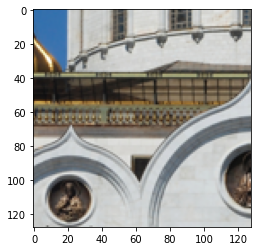

In [ ]:
plt.imshow(img_hr.permute(1, 2, 0))

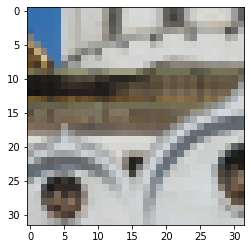

In [ ]:
plt.imshow(img_lr.permute(1, 2, 0))

# TENSORBOARD

In [ ]:
pip install tensorboard-plugin-customizable-plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir runs/PSNR_GENERATOR_3

# TESTING

In [ ]:
### TEST DATASET

transform_both = A.Compose([
    #A.RandomCrop(HR, HR)
    ]
)

transform_hr = A.Compose([
    A.Resize(width=1020, height=768, interpolation=Image.BICUBIC),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2(),
    ]
)

transform_lr = A.Compose([
    A.Resize(width=255, height=192, interpolation=Image.BICUBIC),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2(),
    ]
)


test_ds = SuperResolutionDataset(
    hr_path=ORIGINAL_DS_TEST,
    lr_path=LR_TEST,
    transform_both=transform_both,
    transform_hr=transform_hr,
    transform_lr=transform_lr
)

test_dataloader = DataLoader(dataset=test_ds, batch_size=1, shuffle=False)


In [ ]:
model = Generator(upsample_algo="nearest", num_blocks=2)
model.load_state_dict(torch.load("./models_weights/gen_2blocks/model_100.pt"))
device="cuda"
run_name="PSNR_GENERATOR_3"
image_folder = "./output_images/gen_2blocks_100epochs_images"
name_for_tensorboard = "GENERATOR 2 BLOCKS (100 EPOCHS) METRICS"
logger = SummaryWriter(os.path.join("runs", run_name))

tot_lpips, tot_ssim, tot_psnr = testing_generator(model, test_dataloader, device, logger, image_folder=image_folder, name_for_tensorboard=name_for_tensorboard)
print(tot_lpips, tot_ssim, tot_psnr)

Testing:   0%|          | 0/101 [00:00<?, ?it/s]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:   1%|          | 1/101 [00:10<18:10, 10.91s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:   2%|▏         | 2/101 [00:13<09:34,  5.80s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:   3%|▎         | 3/101 [00:15<06:41,  4.10s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:   4%|▍         | 4/101 [00:16<04:59,  3.09s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:   5%|▍         | 5/101 [00:18<04:08,  2.59s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:   6%|▌         | 6/101 [00:20<03:34,  2.26s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:   7%|▋         | 7/101 [00:21<03:12,  2.05s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:   8%|▊         | 8/101 [00:23<02:59,  1.93s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:   9%|▉         | 9/101 [00:25<02:52,  1.87s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  10%|▉         | 10/101 [00:27<03:00,  1.98s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  11%|█         | 11/101 [00:29<02:49,  1.89s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  12%|█▏        | 12/101 [00:30<02:38,  1.78s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  13%|█▎        | 13/101 [00:32<02:33,  1.75s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  14%|█▍        | 14/101 [00:33<02:29,  1.72s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  15%|█▍        | 15/101 [00:35<02:27,  1.71s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  16%|█▌        | 16/101 [00:37<02:22,  1.68s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  17%|█▋        | 17/101 [00:39<02:32,  1.82s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  18%|█▊        | 18/101 [00:41<02:36,  1.88s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  19%|█▉        | 19/101 [00:42<02:23,  1.75s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  20%|█▉        | 20/101 [00:44<02:20,  1.74s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  21%|██        | 21/101 [00:46<02:17,  1.72s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  22%|██▏       | 22/101 [00:47<02:16,  1.73s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  23%|██▎       | 23/101 [00:49<02:14,  1.72s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  24%|██▍       | 24/101 [00:51<02:11,  1.71s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  25%|██▍       | 25/101 [00:53<02:25,  1.92s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  26%|██▌       | 26/101 [00:55<02:18,  1.84s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  27%|██▋       | 27/101 [00:56<02:09,  1.75s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  28%|██▊       | 28/101 [00:58<02:05,  1.72s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  29%|██▊       | 29/101 [01:00<02:02,  1.70s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  30%|██▉       | 30/101 [01:01<02:01,  1.71s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  31%|███       | 31/101 [01:11<04:47,  4.11s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  32%|███▏      | 32/101 [01:13<03:51,  3.35s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  33%|███▎      | 33/101 [01:14<03:12,  2.83s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  34%|███▎      | 34/101 [01:33<08:25,  7.54s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  35%|███▍      | 35/101 [01:34<06:19,  5.76s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  36%|███▌      | 36/101 [01:36<04:53,  4.52s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  37%|███▋      | 37/101 [01:38<03:52,  3.63s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  38%|███▊      | 38/101 [01:39<03:11,  3.04s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  39%|███▊      | 39/101 [01:41<02:41,  2.61s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  40%|███▉      | 40/101 [01:43<02:34,  2.54s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  41%|████      | 41/101 [01:45<02:19,  2.32s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  42%|████▏     | 42/101 [01:47<02:04,  2.11s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  43%|████▎     | 43/101 [01:48<01:54,  1.98s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  44%|████▎     | 44/101 [01:50<01:47,  1.88s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  45%|████▍     | 45/101 [01:52<01:50,  1.97s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  46%|████▌     | 46/101 [01:54<01:46,  1.93s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  47%|████▋     | 47/101 [02:01<02:57,  3.29s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  48%|████▊     | 48/101 [02:02<02:28,  2.79s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  49%|████▊     | 49/101 [02:04<02:07,  2.45s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  50%|████▉     | 50/101 [02:05<01:52,  2.21s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  50%|█████     | 51/101 [02:07<01:44,  2.09s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  51%|█████▏    | 52/101 [02:09<01:43,  2.12s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  52%|█████▏    | 53/101 [02:11<01:35,  2.00s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  53%|█████▎    | 54/101 [02:13<01:27,  1.86s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  54%|█████▍    | 55/101 [02:14<01:21,  1.78s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  55%|█████▌    | 56/101 [02:36<05:52,  7.83s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  56%|█████▋    | 57/101 [02:38<04:23,  6.00s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  57%|█████▋    | 58/101 [02:40<03:23,  4.73s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  58%|█████▊    | 59/101 [02:42<02:42,  3.86s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  59%|█████▉    | 60/101 [02:43<02:10,  3.19s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  60%|██████    | 61/101 [02:45<01:55,  2.88s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  61%|██████▏   | 62/101 [02:48<01:44,  2.68s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  62%|██████▏   | 63/101 [02:49<01:29,  2.35s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  63%|██████▎   | 64/101 [02:51<01:17,  2.09s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  64%|██████▍   | 65/101 [02:52<01:08,  1.92s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  65%|██████▌   | 66/101 [02:54<01:07,  1.92s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  66%|██████▋   | 67/101 [02:56<01:02,  1.83s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  67%|██████▋   | 68/101 [02:57<00:59,  1.79s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  68%|██████▊   | 69/101 [03:00<01:00,  1.90s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  69%|██████▉   | 70/101 [03:01<00:57,  1.85s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  70%|███████   | 71/101 [03:03<00:54,  1.80s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  71%|███████▏  | 72/101 [03:05<00:51,  1.77s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  72%|███████▏  | 73/101 [03:06<00:49,  1.76s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  73%|███████▎  | 74/101 [03:08<00:46,  1.73s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  74%|███████▍  | 75/101 [03:10<00:44,  1.71s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  75%|███████▌  | 76/101 [03:12<00:46,  1.88s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  76%|███████▌  | 77/101 [03:14<00:46,  1.96s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  77%|███████▋  | 78/101 [03:16<00:43,  1.87s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  78%|███████▊  | 79/101 [03:18<00:39,  1.81s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  79%|███████▉  | 80/101 [03:19<00:37,  1.76s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  80%|████████  | 81/101 [03:41<02:35,  7.80s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  81%|████████  | 82/101 [03:43<01:53,  5.98s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  82%|████████▏ | 83/101 [03:44<01:23,  4.66s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  83%|████████▎ | 84/101 [03:46<01:04,  3.77s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  84%|████████▍ | 85/101 [03:48<00:50,  3.13s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  85%|████████▌ | 86/101 [03:50<00:42,  2.84s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  86%|████████▌ | 87/101 [03:52<00:36,  2.59s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  87%|████████▋ | 88/101 [03:53<00:29,  2.30s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  88%|████████▊ | 89/101 [03:55<00:25,  2.12s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  89%|████████▉ | 90/101 [03:57<00:21,  1.99s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  90%|█████████ | 91/101 [03:59<00:19,  1.97s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  91%|█████████ | 92/101 [04:00<00:16,  1.88s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  92%|█████████▏| 93/101 [04:02<00:14,  1.87s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing:  93%|█████████▎| 94/101 [04:16<00:38,  5.46s/it]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  94%|█████████▍| 95/101 [04:18<00:26,  4.34s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  95%|█████████▌| 96/101 [04:20<00:17,  3.55s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  96%|█████████▌| 97/101 [04:21<00:11,  2.98s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  97%|█████████▋| 98/101 [04:23<00:07,  2.61s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  98%|█████████▊| 99/101 [04:25<00:04,  2.34s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Testing:  99%|█████████▉| 100/101 [04:26<00:02,  2.07s/it]

Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


Testing: 100%|██████████| 101/101 [04:28<00:00,  2.66s/it]

0.31505741636351786 0.8661366146389801 26.55565200879795


# TRAIN

In [ ]:
train(start_epoch=0,
    num_epochs=50,
    device="cuda",
    run_name="PSNR_GENERATOR_3",
    weights_folder="./models_weights/gan_2blocks",
    loss_fn=None,
    #loss_fn=nn.L1Loss(),
    #loss_fn=nn.MSELoss(),                               ### was L1Loss before !!!!!
    batch_size=64,
    lr=0.0001,
    num_blocks_gen=2,
    pretrained_gen=True,
    pretrained_disc=True,
    weights_gen="./models_weights/gen_2blocks/model_200.pt",
    weights_disc="./models_weights/disc/discriminator_50.pt"
    )

Training epoch 0:   0%|          | 0/11 [00:23<?, ?it/s]


OutOfMemoryError: ignored

# TEST MODEL INFERENCE

In [ ]:
### TEST MODEL INFERENCE


generator = Generator(upsample_algo="nearest", num_blocks=10)

generator.load_state_dict(torch.load("./models_weights/model_200.pt")) 

<All keys matched successfully>

In [ ]:
### TEST DATASET

HR = 128
LR = HR//4
#print(LR)


transform_both = A.Compose([
    #A.RandomCrop(HR, HR)
    ]
)

transform_hr = A.Compose([
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2(),
    ]
)

transform_lr = A.Compose([
    A.Resize(width=255, height=192, interpolation=Image.BICUBIC),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2(),
    ]
)


ds = SuperResolutionDataset(
    hr_path=ORIGINAL_DS_VAL,
    lr_path=LR_VAL,
    transform_both=transform_both,
    transform_hr=transform_hr,
    transform_lr=transform_lr
)

In [ ]:
img_hr_lr = ds[17]
img_hr = img_hr_lr[0]
img_lr = img_hr_lr[1]

In [ ]:
img_hr.shape

torch.Size([3, 768, 1020])

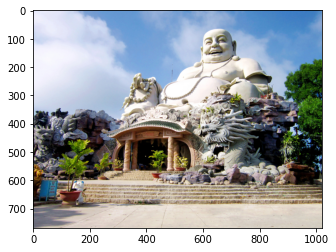

In [ ]:
plt.imshow(img_hr.permute(1, 2, 0))

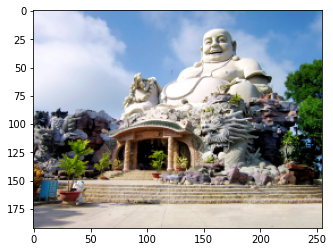

In [ ]:
plt.imshow(img_lr.permute(1, 2, 0))

In [ ]:
out = generator(img_lr.unsqueeze(0)).squeeze(0).permute(1,2,0)
#out = generator(torch.rand((1, 3, 300, 300)))

In [ ]:
out.shape

torch.Size([768, 1020, 3])

In [ ]:
out = (out+1)/2

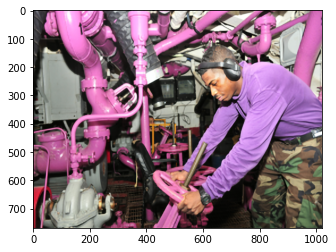

In [ ]:
plt.imshow(out.detach().numpy())
#plt.savefig("./test_inference")

In [ ]:
out.shape

torch.Size([768, 1020, 3])

In [ ]:
to_pil = transforms.ToPILImage()
out_img = to_pil(out.permute(2,0,1))
out_img.save("./test_out_img_87.png")

In [ ]:
path = ""
img = Image.open()

# BASELINES
